In [5]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import StratifiedKFold
import os

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random
from PIL import Image

from torchvision import transforms, models
from torchvision.transforms import functional
from torch.utils.data import ConcatDataset
from matplotlib.animation import FuncAnimation

import shutil 
from tqdm import tqdm

def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)

def fill_list_of_classes(wood_count, wheat_count, stone_count, sheep_count, brick_count):
    list_of_classes = []
    for i in range(wood_count):
        list_of_classes.append(0)
    for i in range(wheat_count):
        list_of_classes.append(1)
    for i in range(stone_count):
        list_of_classes.append(2)
    for i in range(sheep_count):
        list_of_classes.append(3)
    for i in range(brick_count):
        list_of_classes.append(4)

    return list_of_classes

def fill_list_of_images(class_names, list_of_images):

    for class_name in class_names:   
        for file in os.listdir('/kaggle/input/catan-dataset/resources_dataset/resources_dataset/train/'
                               +class_name):
            file_name = os.fsdecode(file)
            if (file.endswith(".png")):             
                list_of_images.append(file_name)

def count_files(path_dir):
    cpt = sum([len(files) for r, d, files in os.walk(path_dir)])
    wood_count = sum([len(files) for r, d, files in os.walk(path_dir + "/wood")])
    wheat_count = sum([len(files) for r, d, files in os.walk(path_dir+ "/wheat")])
    stone_count = sum([len(files) for r, d, files in os.walk(path_dir + "/stone")])
    brick_count = sum([len(files) for r, d, files in os.walk(path_dir + "/brick")])
    sheep_count = sum([len(files) for r, d, files in os.walk(path_dir + "/sheep")])
    print(wood_count, wheat_count, stone_count, sheep_count, brick_count, cpt)
    return wood_count, wheat_count, stone_count, sheep_count, brick_count

def fill_val_folders(list_of_images,list_of_classes,train_dir,val_dir):
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(strat_kfold.split(list_of_images,list_of_classes)):
        
        if fold == 0:
            for each_id in test_ids:
                if list_of_classes[each_id] == 0:
                    shutil.move(train_dir + '/wood/'+list_of_images[each_id], val_dir+'/wood/'+list_of_images[each_id])    
                elif list_of_classes[each_id] == 1:
                    shutil.move(train_dir + '/wheat/'+list_of_images[each_id], val_dir+'/wheat/'+list_of_images[each_id])
                elif list_of_classes[each_id] == 2:
                    shutil.move(train_dir + '/stone/'+list_of_images[each_id], val_dir+'/stone/'+list_of_images[each_id])
                elif list_of_classes[each_id] == 3:
                    shutil.move(train_dir + '/sheep/'+list_of_images[each_id], val_dir+'/sheep/'+list_of_images[each_id])
                elif list_of_classes[each_id] == 4:
                    shutil.move(train_dir + '/brick/'+list_of_images[each_id], val_dir+'/brick/'+list_of_images[each_id])

def create_blank_model(device, freeze_layers = True):
    model = models.resnet34(pretrained=True)
    if freeze_layers:
        for param in model.parameters():
            #if isinstance(param, torch.nn.Conv2d):
                param.requires_grad = False

    model.fc = torch.nn.Linear(model.fc.in_features, 5)    
    model = model.to(device)
    return model


def create_train_transforms():

    train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.CenterCrop(60),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])   
    return train_transforms

def create_val_transforms():
    val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.CenterCrop(60),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return val_transforms


def create_optimizer(model,learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    return optimizer
    
def create_scheduler(optimizer,step_size,gamma):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    return optimizer


def get_train_val_dataloaders(num_of_augmentaions,train_dir,val_dir,batch_size):
    list_of_train_datasets = []        

    for i in range(num_of_augmentaions):
        
        train_transforms = create_train_transforms()
        train_dataset = torchvision.datasets.ImageFolder(train_dir,train_transforms)   
        
        list_of_train_datasets.append(train_dataset)
            
    train_dataset = ConcatDataset(list_of_train_datasets)

    val_transforms = create_val_transforms()
    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size,drop_last=True)

    return train_dataloader, val_dataloader

In [6]:
def train_model(device,model, loss,optimizer, 
                scheduler,accuracy_history_train,accuracy_history_val,
                epoch_history,train_dataloader,val_dataloader, num_epochs):    
    best_val_acc = 0
    best_train_acc = 0
    for epoch in tqdm(range(num_epochs)):
        
        epoch_history.append(epoch)
        #print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                #print(preds_class)
                #print(labels.data)
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                accuracy_history_train.append(epoch_acc.item())
            else:
                if epoch_acc.item() >= best_val_acc:
                    #print('best model - ' + str(epoch_acc.item()) + ' val accuracy')
                    torch.save(model.state_dict(),
                               '/kaggle/working/best_model.pt')
                    best_val_acc = epoch_acc.item() 
                
                    #print(model.state_dict())
                    #best_model = model.state_dict()
                accuracy_history_val.append(epoch_acc.item())

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [8]:
set_random_seed(0)

train_dir = '/kaggle/input/catan-dataset/resources_dataset/resources_dataset/train'
val_dir = '/kaggle/input/catan-dataset/resources_dataset/resources_dataset/val'
batch_size = 8
best_model = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
list_of_images = []
class_names = ['wood','wheat','stone','sheep','brick']
wood_count, wheat_count, stone_count, sheep_count, brick_count = count_files(
    '/kaggle/input/catan-dataset/resources_dataset/resources_dataset/train')

list_of_classes = fill_list_of_classes(wood_count, wheat_count, stone_count, sheep_count, brick_count)
fill_list_of_images(class_names, list_of_images)
#fill_val_folders(list_of_images,list_of_classes,train_dir,val_dir)

count_files('/kaggle/input/catan-dataset/resources_dataset/resources_dataset/train')
count_files('/kaggle/input/catan-dataset/resources_dataset/resources_dataset/val')

tr_transforms = create_train_transforms()
learning_rate =1.0e-3
step_size=7
gamma=0.1
model_name = 'Resnet34'
model_freezed = 'except last layer'
num_of_epochs = 60
num_of_augmentaions = 1
optimizer_name = 'Adam'

train_dataloader,val_dataloader = get_train_val_dataloaders(num_of_augmentaions,
                                                            train_dir,
                                                            val_dir,
                                                            batch_size)

72 71 111 42 96 392
72 71 111 42 96 392
19 17 28 10 24 98


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]
100%|██████████| 60/60 [02:12<00:00,  2.20s/it]


0.9948979616165161
0.9895833730697632


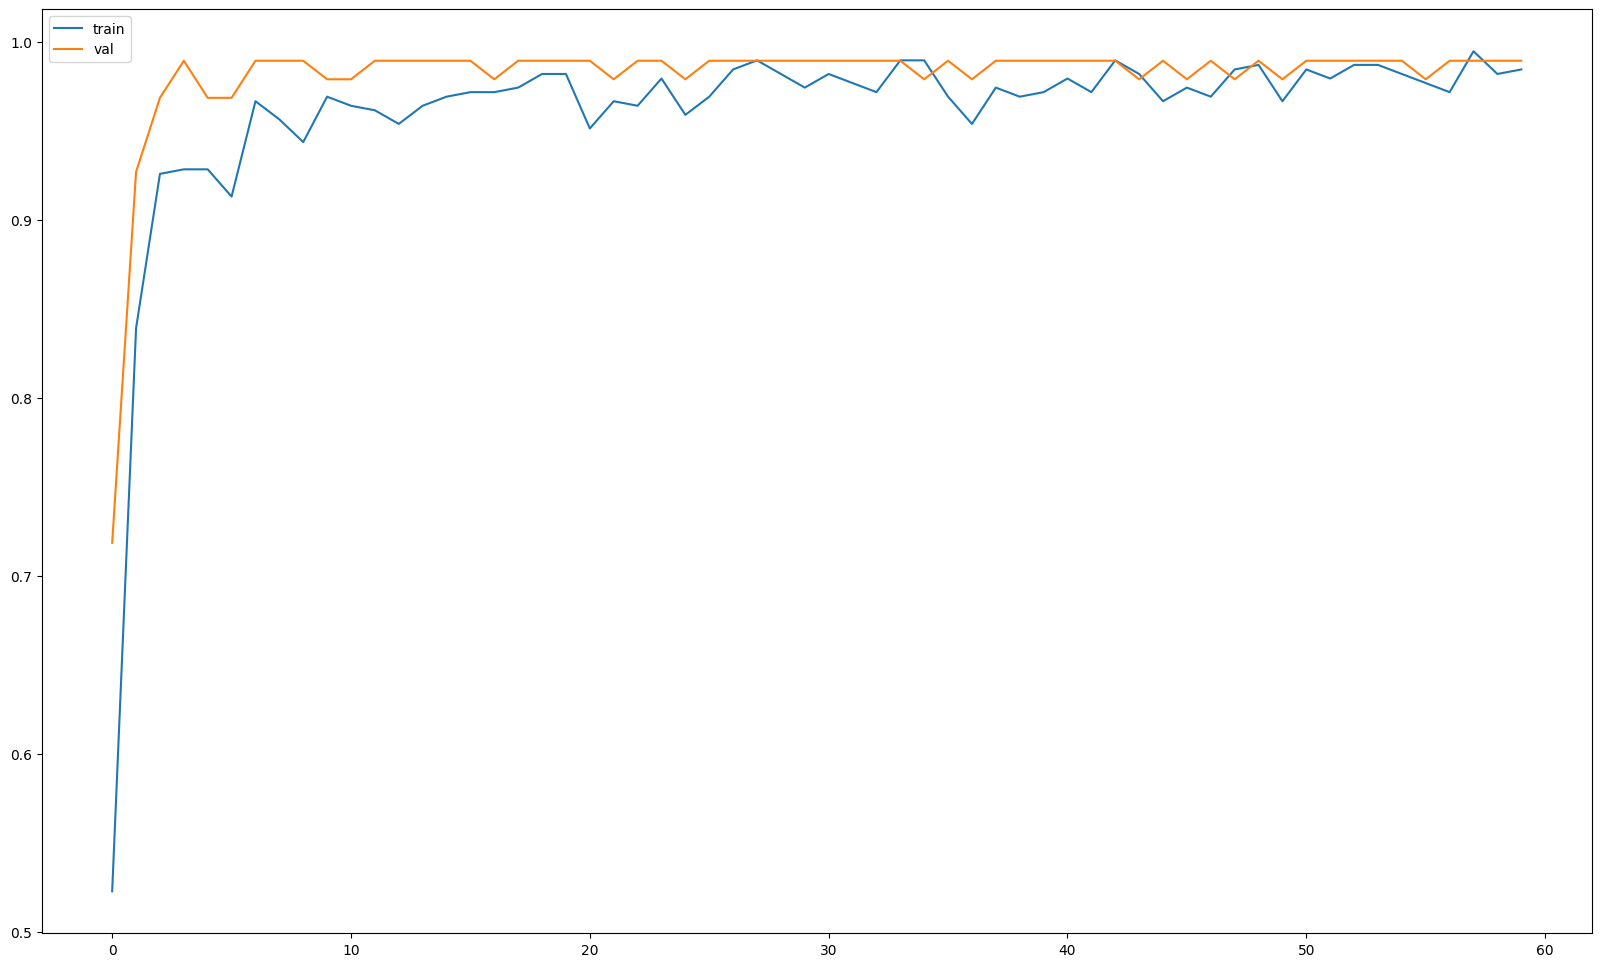

In [9]:
model = create_blank_model(device)
loss = torch.nn.CrossEntropyLoss()  
optimizer = create_optimizer(model,learning_rate)
scheduler = create_scheduler(optimizer,step_size,gamma)
train_dataloader,val_dataloader = get_train_val_dataloaders(num_of_augmentaions,
                                                            train_dir,
                                                            val_dir,
                                                            batch_size)

epoch_history = []
accuracy_history_train = []
accuracy_history_val = []
train_model(device,model,
            loss, 
            optimizer, 
            scheduler, 
            accuracy_history_train,
            accuracy_history_val,
            epoch_history,
            train_dataloader,
            val_dataloader,
            num_of_epochs)

print(max(accuracy_history_train))
print(max(accuracy_history_val))
plt.figure(figsize=(20,12))
plt.plot(epoch_history ,accuracy_history_train,label = 'train')
plt.plot(epoch_history ,accuracy_history_val,label = 'val')
plt.legend()
plt.show()

In [ ]:
for ind, (inputs, labels) in enumerate(train_dataloader):
    #print(inputs.shape)
    y_onehot = torch.zeros(batch_size, len(class_names))
    y_onehot.scatter_(1, labels.unsqueeze(dim=1), 1)
    print(y_onehot)
    print(y_onehot.shape)
    print(labels)
    break

In [2]:
res = [2,2,3,5]

    

In [10]:
print('\n'.join(str(x) for x in res))

2
2
3
5
